# Amazon Product Review Sentiment Analysis

## BBM 409: Machine Learning Laboratory Assignment 3

### Introduction

In this assignment, we implement a sentiment analysis system for Amazon product reviews using a Naive Bayes classifier with a bag-of-words approach. The primary objective is to classify reviews as either positive or negative based on their textual content. A key requirement is to incorporate a weight factor system that accounts for different intensity levels of sentiment (1-star reviews being more negative than 2-star reviews, and 5-star reviews being more positive than 4-star reviews).

Sentiment analysis is a fundamental natural language processing task with numerous real-world applications, including:
- Understanding customer feedback for product improvement
- Monitoring brand reputation
- Prioritizing customer service responses
- Enhancing recommendation systems

### Required Libraries
We'll start by importing the necessary libraries for our analysis:

In [1]:
import pandas as pd                                  #!pip install pandas==2.2.3
import numpy as np                                   #!pip install numpy==1.26.4
import matplotlib.pyplot as plt                      #!pip install matplotlib==3.9.4
import seaborn as sns                                #!pip install seaborn==0.13.2
import re                                            #!pip install re==2.2.1
import math
from wordcloud import WordCloud                      #!pip install wordcloud==1.9.4
from collections import defaultdict,Counter
from sklearn.model_selection import train_test_split    #!pip install scikit-learn==1.2.2
from textblob import TextBlob                           #!pip install textblob== 0.19.0
import spacy                                            #!pip install spacy==3.7.5

sns.set(style="whitegrid")

### Data Import and Exploration

First, we load the Amazon product reviews dataset and explore its basic properties.

In [2]:
df = pd.read_csv("amazon_reviews.csv")
df.head()

,Title,Content,Star
0,Didn't work,No change in nails at all.,1.0
1,Worst nail product I have ever used.,Garbage! Do not waste your $$$. My nails were ...,1.0
2,Just didn't work,Nails are still brittle,1.0
3,Scum,Didn’t do any improvement at all.,1.0
4,Okay for cuticles,"Helped cuticles, didn't do much for my nails. ...",1.0


The dataset contains reviews of Amazon products with three columns:
- **Title**: The title of the review
- **Content**: The main text of the review
- **Star**: The rating given by the user (1-5 stars)

Let's check the data types and look for missing values:

In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72500 entries, 0 to 72499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Title    72480 non-null  object 
 1   Content  72493 non-null  object 
 2   Star     72500 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.7+ MB


Title      20
Content     7
Star        0
dtype: int64

We found a small number of missing values (20 missing titles and 7 missing content entries), which will be handled during preprocessing.

Let's examine the distribution of star ratings in our dataset:

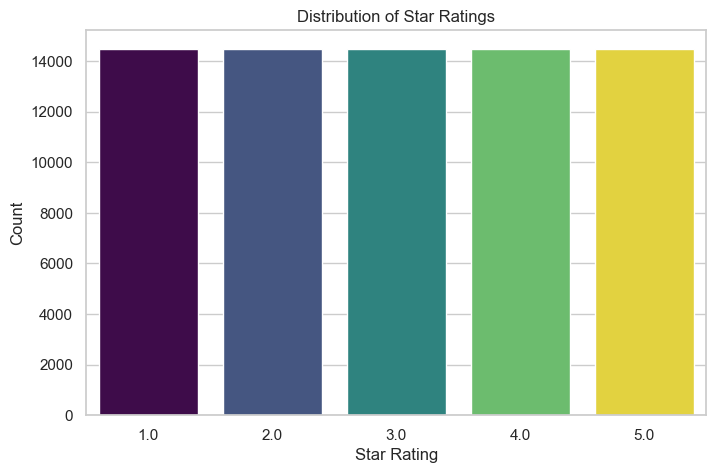

In [4]:
star_counts = df["Star"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=star_counts.index, y=star_counts.values, hue=star_counts.index, palette="viridis", legend=False)
plt.title("Distribution of Star Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.show()

The dataset is well-balanced with an equal number of reviews for each star rating.

### Data Preprocessing

#### Text Processing Approach: Combining Title and Content

The assignment specified two possible approaches for handling the title and content fields:
1. Process title and content separately, giving appropriate weights to each based on their importance
2. Combine title and content into a single text field for unified processing

We chose to combine the title and content fields into a single text field for analysis, based on the following reasoning:

**1. Semantic Completeness**
- Titles often serve as summaries or key highlights of the review content
- The full meaning of a review is best captured when both components are considered together
- Processing them as a unified entity preserves the complete semantic context

**2. Feature Consistency**
- Treating title and content as a single document ensures that related terms appearing in both fields reinforce each other
- This approach avoids artificial separation of concepts that span both fields
- The natural language patterns across the complete review are preserved

**3. Implementation Simplicity**
- A unified approach reduces model complexity and avoids the need to determine arbitrary weights
- The weight determination between title and content would introduce an additional hyperparameter requiring tuning
- Simpler models are often more robust and less prone to overfitting

**4. Precedent in NLP Research**
- Many sentiment analysis studies in the literature treat review titles and bodies as a single document
- This approach aligns with standard practices in document classification

**5. Focus on Sentiment Intensity**
- Our primary goal is to implement a weight factor system based on star ratings
- By combining title and content, we can focus more directly on the core requirement of weighting by sentiment intensity
- The star-based weight factor system provides a data-driven approach to assigning importance based on sentiment strength

While a weighted approach might have captured the potentially higher information density in titles, we determined that the benefits of a unified representation outweighed the potential advantages of separate processing. This decision aligns with our overall goal of building a straightforward yet effective sentiment analysis system.

In [5]:
df["Text_preview"] = df["Title"].astype(str) + " " + df["Content"].astype(str)

df["Text_preview"].iloc[0]


"Didn't work No change in nails at all."

Next, we define a function to clean the text:

In [6]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove all non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

This function performs the following operations:
1. Converts text to lowercase
2. Removes all non-alphabetic characters
3. Removes extra whitespace

We apply this function to our combined text:

In [7]:
def merge_text(title, content):
    return title + " " + content

df["Merged_text"] = df.apply(lambda x: merge_text(str(x["Title"]), str(x["Content"])), axis=1)
df["Clean_text"] = df["Merged_text"].apply(clean_text)
df["Clean_text"].head()

0                 didnt work no change in nails at all
1    worst nail product i have ever used garbage do...
2              just didnt work nails are still brittle
3                 scum didnt do any improvement at all
4    okay for cuticles helped cuticles didnt do muc...
Name: Clean_text, dtype: object

#### Handling 3-Star Reviews

The assignment provided two options for dealing with 3-star reviews:
1. Treat them as a separate "neutral" class in a three-class classification problem
2. Dismiss them entirely to focus on binary sentiment classification

We chose the second approach—removing 3-star reviews from our dataset—for several compelling reasons:

1. **Ambiguity in Neutral Sentiment**: 3-star reviews often contain mixed sentiments with both positive and negative aspects, making them inherently ambiguous. This ambiguity can introduce noise into our model and decrease overall classification performance.

2. **Clearer Decision Boundary**: By focusing exclusively on clearly positive (4-5 stars) and negative (1-2 stars) reviews, we create a more distinct classification boundary. This allows our Naive Bayes model to learn more clearly separated feature distributions.

3. **Simplicity and Performance**: Binary classification is generally simpler and often performs better than multi-class classification, especially with probabilistic models like Naive Bayes. This approach aligns with Occam's razor—choosing the simplest solution that adequately solves the problem.

4. **Research Precedent**: Many sentiment analysis studies in the literature follow this approach of focusing on clearly positive and negative instances, particularly when working with review data that has a 5-star scale.

5. **Focus on Weight Factor System**: Our primary goal is to implement and evaluate a weight factor system that distinguishes between different intensities of positive and negative sentiment. By removing the neutral class, we can focus more effectively on this core requirement.

This decision creates a more focused dataset where the key challenge becomes distinguishing between different intensities of sentiment (1 vs. 2 stars and 4 vs. 5 stars) rather than distinguishing between positive, neutral, and negative classes.

In [8]:
df = df[df["Star"] != 3]
print(df["Star"].value_counts())

Star
1.0    14500
2.0    14500
4.0    14500
5.0    14500
Name: count, dtype: int64


### Binary Sentiment Labeling

Next, we create a binary sentiment label based on the star ratings:
- 1-2 stars: Negative (0)
- 4-5 stars: Positive (1)
  
Then visualize the distribution of positive and negative sentiments:

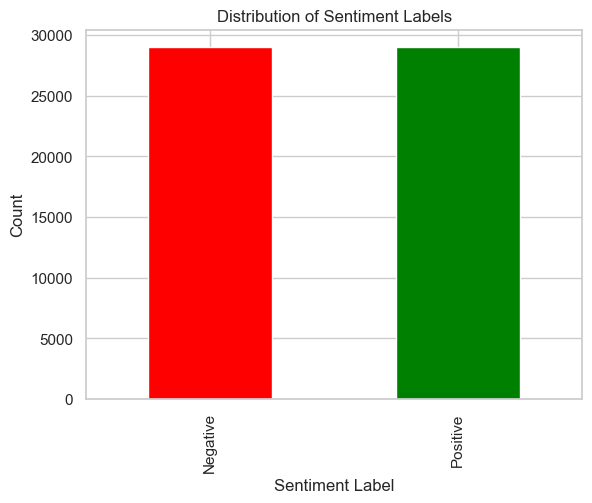

In [9]:
def label_sentiment(star):
    if star in [1, 2]:
        return 0  # Negative
    elif star in [4, 5]:
        return 1  # Positive

df["Label"] = df["Star"].apply(label_sentiment)
df["Label"].value_counts()
df["Label"].value_counts().plot(kind="bar", color=["red", "green"])
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.show()

The dataset is perfectly balanced with an equal number of positive and negative reviews.

### Word Clouds to Visualize Important Words

Let's create word clouds to visualize the most common words in positive and negative reviews:

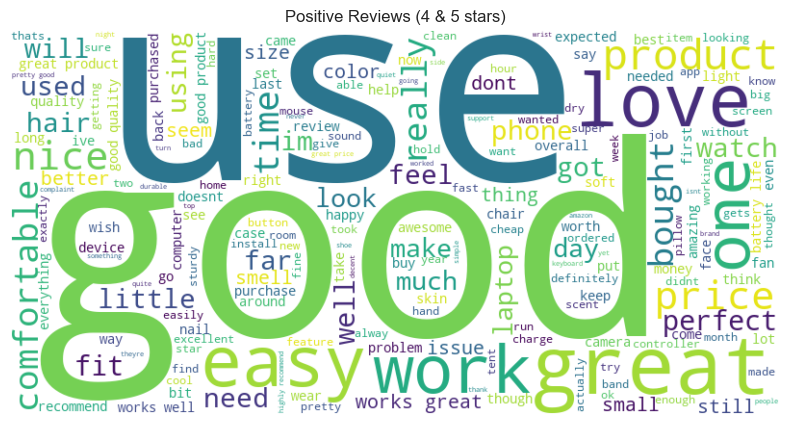

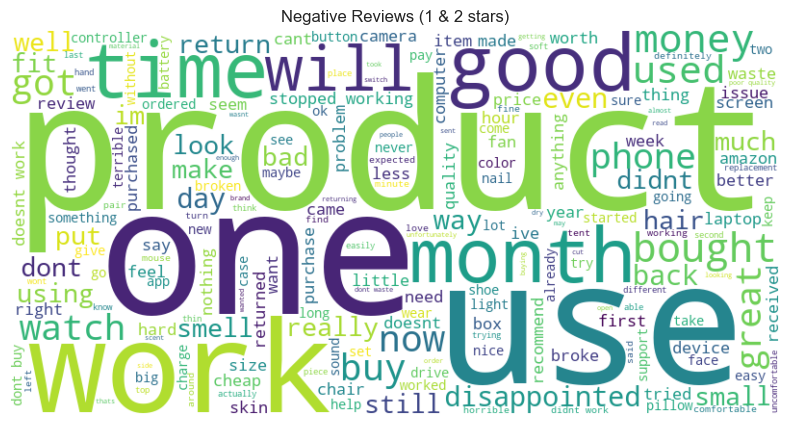

In [10]:
def plot_wordcloud(data, label, title):
    text = " ".join(data[data['Label'] == label]['Clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Word clouds
plot_wordcloud(df, 1, "Positive Reviews (4 & 5 stars)")
plot_wordcloud(df, 0, "Negative Reviews (1 & 2 stars)")


### Word Count Analysis

Let's analyze the length of reviews to see if there's any correlation between review length and sentiment:

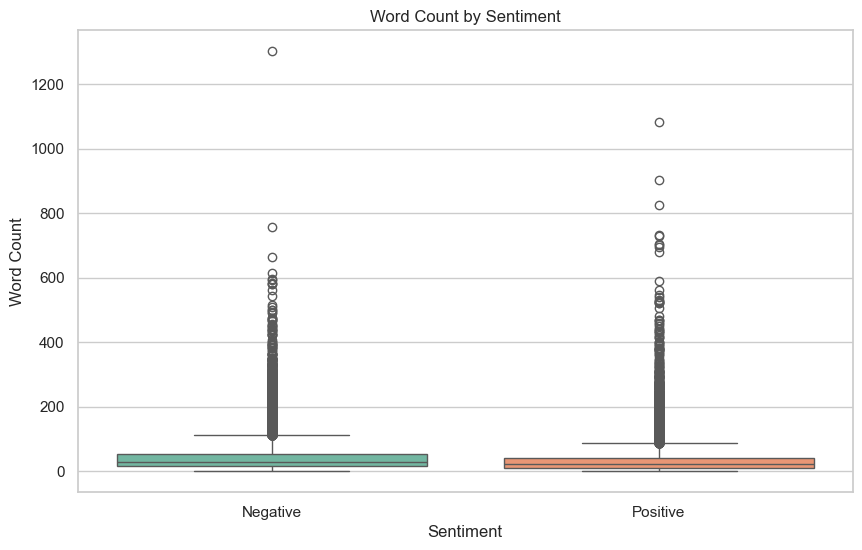

Average words in negative reviews: 43.21
Average words in positive reviews: 34.33


In [11]:
# Add word count column
df["word_count"] = df["Clean_text"].apply(lambda x: len(x.split()))

# Create a boxplot to visualize word count by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x="Label", y="word_count", data=df, hue="Label", palette="Set2", legend=False)
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.title("Word Count by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Word Count")
plt.show()

# Calculate average word counts
avg_negative = df[df["Label"] == 0]["word_count"].mean()
avg_positive = df[df["Label"] == 1]["word_count"].mean()

print(f"Average words in negative reviews: {avg_negative:.2f}")
print(f"Average words in positive reviews: {avg_positive:.2f}")


Interestingly, negative reviews tend to be longer than positive reviews, with negative reviews having an average of 43.21 words compared to 34.33 words for positive reviews. This might suggest that users write more detailed explanations when they are dissatisfied with a product.

## Sentiment Subjectivity Analysis

This visualization analyzes the subjectivity scores of reviews using TextBlob. Subjectivity measures how much text contains opinions/emotions (1.0) versus factual information (0.0).



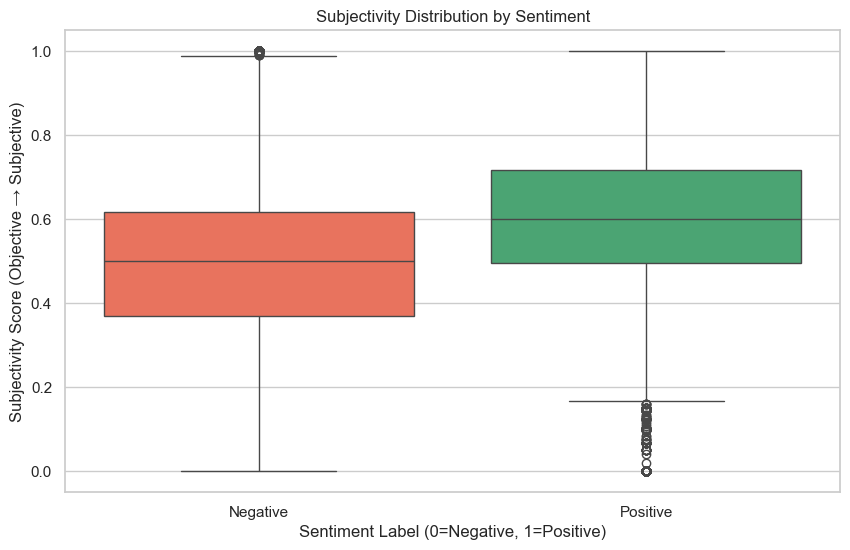

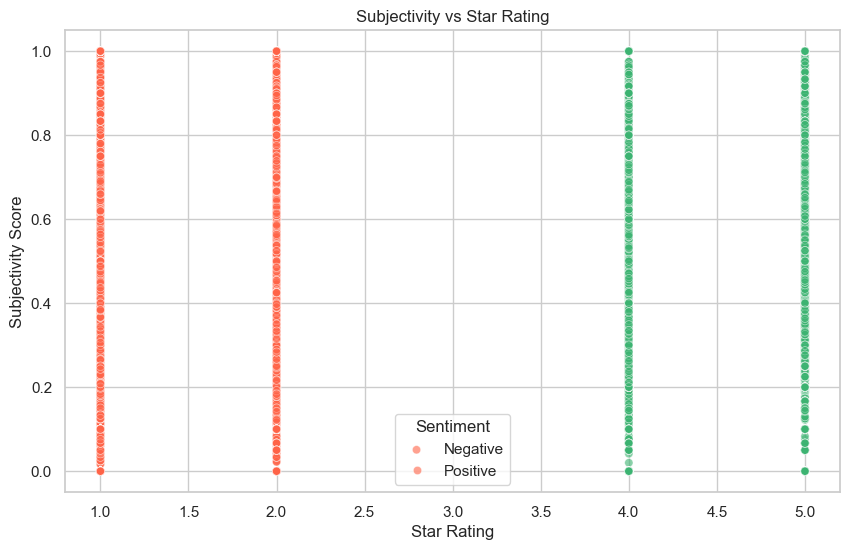


Average subjectivity by star rating:
1.0 stars: 0.4691
2.0 stars: 0.4947
4.0 stars: 0.5654
5.0 stars: 0.6126


In [12]:
# Calculate sentiment polarity and subjectivity
df['subjectivity'] = df['Clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Create box plots for subjectivity by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='subjectivity', data=df, hue='Label', palette=['tomato', 'mediumseagreen'], legend=False)
plt.title('Subjectivity Distribution by Sentiment')
plt.xlabel('Sentiment Label (0=Negative, 1=Positive)')
plt.ylabel('Subjectivity Score (Objective → Subjective)')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

# Create scatter plot of subjectivity vs star rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Star', y='subjectivity', data=df, hue='Label', 
                palette=['tomato', 'mediumseagreen'], alpha=0.6)
plt.title('Subjectivity vs Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Subjectivity Score')
plt.legend(title='Sentiment', labels=['Negative', 'Positive'])
plt.show()

# Calculate and display average subjectivity by star rating
subj_by_star = df.groupby('Star')['subjectivity'].mean().reset_index()
print("\nAverage subjectivity by star rating:")
for _, row in subj_by_star.iterrows():
    print(f"{row['Star']} stars: {row['subjectivity']:.4f}")

The boxplot shows positive reviews tend to be more subjective than negative reviews, with median subjectivity scores of ~0.6 for positive reviews versus ~0.5 for negative reviews.

The scatter plot confirms this pattern across star ratings, with lower-rated reviews (1-2 stars) showing lower subjectivity scores and higher-rated reviews (4-5 stars) showing higher subjectivity.

This suggests that customers use more emotional and opinion-based language when expressing satisfaction, while they tend to be more factual when describing negative experiences.

## Named Entity Recognition Analysis

This visualization analyzes the distribution of named entities detected in product reviews using spaCy's NER model. Named entities are real-world objects like people, places, organizations, and dates that can be identified in text.

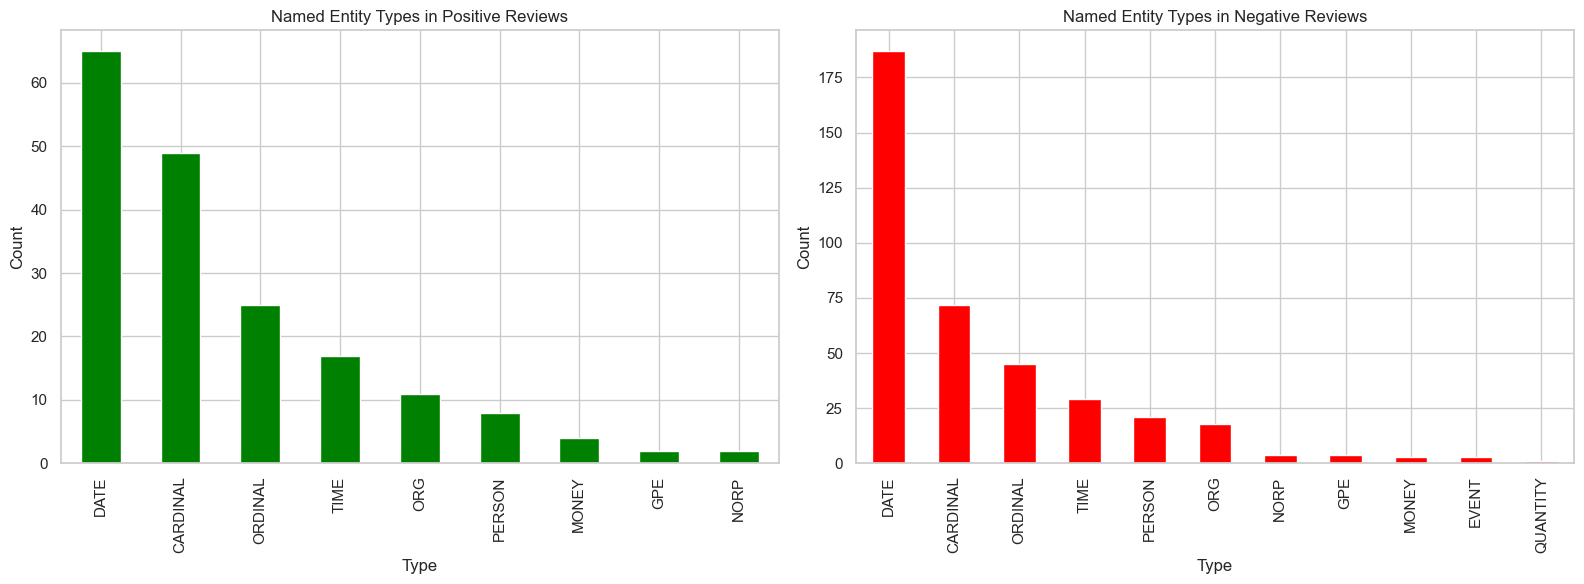

In [13]:
nlp = spacy.load("en_core_web_sm")

# Function to extract entities (sample to reduce processing time)
def extract_entities(texts, sample_size=500):
    entities = []
    
    if len(texts) > sample_size:
        sampled_texts = texts.sample(sample_size, random_state=42)
    else:
        sampled_texts = texts
    
    for text in sampled_texts:
        doc = nlp(text)
        for ent in doc.ents:
            entities.append((ent.text, ent.label_))
    
    return pd.DataFrame(entities, columns=['Entity', 'Type'])

# Extract entities from positive and negative reviews
pos_entities = extract_entities(df[df['Label'] == 1]['Clean_text'])
neg_entities = extract_entities(df[df['Label'] == 0]['Clean_text'])

# Count entity types
pos_entity_counts = pos_entities['Type'].value_counts()
neg_entity_counts = neg_entities['Type'].value_counts()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

pos_entity_counts.plot(kind='bar', ax=axes[0], color='green')
axes[0].set_title('Named Entity Types in Positive Reviews')
axes[0].set_ylabel('Count')

neg_entity_counts.plot(kind='bar', ax=axes[1], color='red')
axes[1].set_title('Named Entity Types in Negative Reviews')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

The bar charts reveal distinct patterns in how customers reference named entities in positive vs. negative reviews:

**Key Observations:**
- **DATE entities** are the most common type in both positive and negative reviews, but appear over twice as frequently in negative reviews. This suggests customers often mention timeframes when expressing dissatisfaction (e.g., "stopped working after two days").

- **CARDINAL and ORDINAL** (numeric) entities appear prominently in both review types, with higher frequencies in negative reviews. This indicates quantitative details are important in customer feedback, especially when highlighting problems.

- **PERSON and ORG** entities appear in both positive and negative reviews, suggesting mentions of customer service representatives or company names in feedback.

- **MONEY** entities appear in both review types but have very low frequency in negative reviews, potentially indicating that price concerns are not a primary driver of negative sentiment.

This analysis shows that negative reviews tend to contain more named entities overall, especially dates and measurements, indicating more specific and detailed information is provided when customers are dissatisfied with products.

### Preparing Data for Model Training

We split our data into training and testing sets, ensuring that we preserve both the binary labels and the original star ratings:

In [14]:
x = df["Clean_text"].values
y = df["Label"].values # Binary sentiment: 0 (negative) or 1 (positive)
stars = df["Star"].values  # Original star ratings (1, 2, 4, 5)
# Split data with stratification to maintain class distribution
x_train, x_test, y_train, y_test, stars_train, stars_test = train_test_split(x, y, stars, test_size=0.2, random_state=42, stratify=y)

### N-gram Generation

We implement a function to generate n-grams from text, which will be used for our bag-of-words model:

In [15]:
def generate_ngrams(text, n=1):
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

## Evaluation Metrics for Binary Classification

This implementation provides a complete set of evaluation metrics tailored for binary classification tasks. These metrics go beyond basic accuracy to give deeper insights into model performance.

### Implemented Functions

1. **`confusion_matrix(y_true, y_pred)`**
   - Builds a confusion matrix dynamically from unique labels in `y_true` and `y_pred`.
   - Uses label-to-index mapping for generalization beyond binary classification.
   - Returns a 2D matrix with counts of actual vs. predicted values.

2. **`accuracy_score(y_true, y_pred)`**
   - Computes the proportion of correct predictions:  
     $$
     \text{Accuracy} = \frac{\text{TP + TN}}{\text{TP + TN + FP + FN}}
     $$

3. **`precision_score(y_true, y_pred)`**
   - Measures how many predicted positives are actually positive:  
     $$
     \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
     $$
   - Returns `0.0` if no positive predictions are made (avoids division by zero).

4. **`recall_score(y_true, y_pred)`**
   - Measures how many actual positives are correctly predicted:  
     $$
     \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
     $$
   - Also returns `0.0` when there are no actual positives.

5. **`f1_score(precision, recall)`**
   - Harmonic mean of precision and recall:  
     $$
     \text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
     $$
   - Ensures stability by returning `0.0` when both precision and recall are `0`.

6. **`plot_confusion_matrix(cm, title)`**
   - Plots the confusion matrix as a heatmap using `seaborn`.
   - Uses fixed class labels `'Negative'` and `'Positive'` for binary tasks.
   - Improves interpretability with annotations and color intensity.

---

In [16]:
def confusion_matrix(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Arrays must have the same length.")
    
    # Unique labels gathered from both true and predicted
    labels = sorted(set(np.concatenate([y_true, y_pred])))
    n_labels = len(labels)
    
    # A mapping from label to index is created
    label_to_index = {label: i for i, label in enumerate(labels)}
    
    # Confusion matrix is initialized
    cm = np.zeros((n_labels, n_labels), dtype=int)
    
    # Confusion matrix is filled
    for true, pred in zip(y_true, y_pred):
        i = label_to_index[true]
        j = label_to_index[pred]
        cm[i, j] += 1
    
    return cm
    
def accuracy_score(y_true, y_pred):
    correct = sum([1 if yt == yp else 0 for yt, yp in zip(y_true, y_pred)])
    return correct / len(y_true)

def precision_score(y_true, y_pred):
    tp = sum([1 for yt, yp in zip(y_true, y_pred) if yt == 1 and yp == 1])
    fp = sum([1 for yt, yp in zip(y_true, y_pred) if yt == 0 and yp == 1])
    if tp + fp == 0:
        return 0.0  # Avoid division by zero
    return tp / (tp + fp)

def recall_score(y_true, y_pred):
    tp = sum([1 for yt, yp in zip(y_true, y_pred) if yt == 1 and yp == 1])
    fn = sum([1 for yt, yp in zip(y_true, y_pred) if yt == 1 and yp == 0])
    if tp + fn == 0:
        return 0.0  # Avoid division by zero
    return tp / (tp + fn)

def f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0  # Avoid division by zero
    return 2 * (precision * recall) / (precision + recall)


    
# Function to plot a confusion matrix as a heatmap
def plot_confusion_matrix(cm, title):    
    # Create figure and plot heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],  # X-axis class labels
                yticklabels=['Negative','Positive'])  # Y-axis class labels
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Naive Bayes Implementation with Weight Factor

Now we implement our custom Naive Bayes classifier that incorporates a weight factor system to account for sentiment intensity. The weight factor gives more importance to extreme reviews (1-star and 5-star) compared to moderate reviews (2-star and 4-star).

In [17]:
class NaiveBayesBoW:
    def __init__(self, ngram_range=(1, 2)):
        self.ngram_range = ngram_range
        self.class_word_counts = {0: Counter(), 1: Counter()}
        self.class_doc_counts = {0: 0, 1: 0}
        self.vocab = set()
        self.total_words = {0: 0, 1: 0}
        self.priors = {}

    def get_weight(self, star):

        if star == 1:
            return 2.0  # Very negative (stronger weight)
        elif star == 2:
            return 1.0  # Negative (standard weight)
        elif star == 4:
            return 1.0  # Positive (standard weight)
        else: # star = 5 
            return 2.0  # Very positive (stronger weight)

    def fit(self, X, y, stars_train):
    
        self.vocab = set()
        self.class_doc_counts = {0: 0, 1: 0}
        self.class_word_counts = {0: {}, 1: {}}
        self.total_words = {0: 0, 1: 0}
        
        for text, label, star in zip(X, y, stars_train):
            self.class_doc_counts[label] += 1
            tokens = []
            
            # Generate n-grams based on the specified range
            for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
                tokens.extend(generate_ngrams(text, n=n))
            
            # Get weight based on star rating
            weight = self.get_weight(star)
            
            # Apply weight by duplicating tokens
            weighted_tokens = []
            for token in tokens:
                self.vocab.add(token)
                # Apply weight by duplicating tokens based on weight
                for _ in range(int(weight)):
                    weighted_tokens.append(token)
            
            # Update token counts for the class
            for token in weighted_tokens:
                if token not in self.class_word_counts[label]:
                    self.class_word_counts[label][token] = 0
                self.class_word_counts[label][token] += 1
            
            # Update total word count for the class
            self.total_words[label] += len(weighted_tokens)

        # Calculate prior probabilities for each class
        total_docs = sum(self.class_doc_counts.values())
        self.priors = {label: count / total_docs for label, count in self.class_doc_counts.items()}

    def predict(self, X):
      
        predictions = []
        for text in X:
            tokens = []
            for n in range(self.ngram_range[0], self.ngram_range[1] + 1):
                tokens.extend(generate_ngrams(text, n=n))

            class_scores = {}
            for label in [0, 1]:
                # Start with the log prior probability
                log_prob = math.log(self.priors[label])
                total_words = self.total_words[label]
                word_counts = self.class_word_counts[label]
                V = len(self.vocab)

                # Add log probabilities for each token (using Laplace smoothing)
                for token in tokens:
                    count = word_counts.get(token, 0)
                    prob = (count + 1) / (total_words + V)
                    log_prob += math.log(prob)
                
                class_scores[label] = log_prob
            
            # Choose the class with the highest log probability
            predicted_label = max(class_scores, key=class_scores.get)
            predictions.append(predicted_label)
        
        return predictions
    
    def evaluate(self, X, y_true):
      
        y_pred = self.predict(X)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_true, y_pred)
        
        # Calculate precision, recall, and F1 score
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(precision, recall)
        cm = confusion_matrix(y_true,y_pred)
        return {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1_Score": f1,
            "confusion_matrix":cm
        }

def generate_ngrams(text, n=2):
  
    words = text.split()
    ngrams = [tuple(words[i:i+n]) for i in range(len(words) - n + 1)]
    return ngrams


### Key Features of Our Implementation:

1. **Weight Factor System**: 
   - 1-star and 5-star reviews (extreme sentiments) receive a weight of 2.0
   - 2-star and 4-star reviews (moderate sentiments) receive a weight of 1.0
   - This ensures that words from strongly positive or negative reviews have more influence on the model

2. **N-gram Support**: 
   - Flexibility to use different n-gram ranges (unigram, bigram, or a combination)
   - Allows capturing more context in the text

3. **Logarithmic Probabilities**: 
   - Used to prevent numerical underflow when multiplying many small probabilities
   - Follows the principle that log(a*b) = log(a) + log(b)

4. **Laplace Smoothing**: 
   - Adds a small constant (1) to all word counts to handle unseen words
   - Prevents zero probabilities that would otherwise dominate the calculations

### Model Training and Evaluation

Let's train our model with a combination of unigrams and bigrams and evaluate its performance:

Accuracy: 0.8998
Precision: 0.8978
Recall: 0.9024
F1_Score: 0.9001


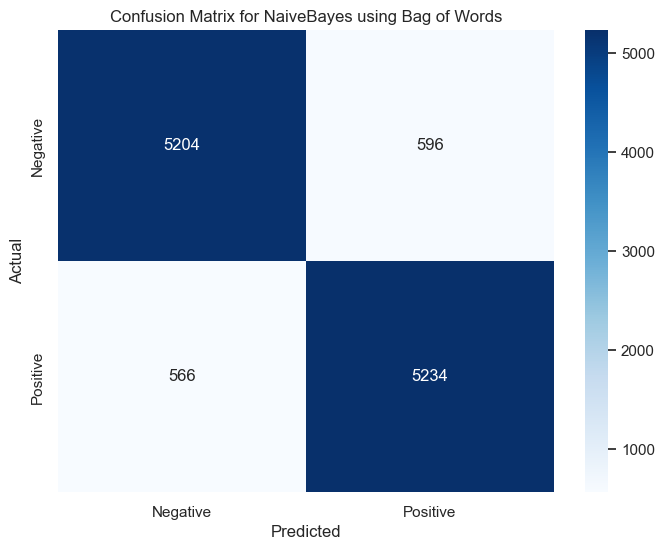

In [18]:
model = NaiveBayesBoW(ngram_range=(1, 2))
model.fit(x_train, y_train,stars_train)
results = model.evaluate(x_test, y_test)

for metric, value in results.items():
    if metric != "confusion_matrix":
        print(f"{metric}: {value:.4f}")
    else:
        plot_confusion_matrix(value, "Confusion Matrix for NaiveBayes using Bag of Words")

The model achieves excellent performance with approximately 90% accuracy, precision, recall, and F1 score.

### Comparing Different N-gram Configurations

Now, let's compare the performance of different n-gram configurations:

In [19]:
def run_experiment(ngram_range, X_train, X_test, y_train, y_test, stars_train, label):
    print(f"\n--- {label} ---")
    model = NaiveBayesBoW(ngram_range=ngram_range)
    model.fit(X_train, y_train,stars_train)
    results = model.evaluate(X_test, y_test)
    for metric, value in results.items():   
        if metric != "confusion_matrix":
            print(f"{metric}: {value:.4f}")
        else:
            plot_confusion_matrix(value, "Confusion Matrix for NaiveBayes using Bag of Words")
    return (label, results)

results_summary = []



--- Unigram Only ---
Accuracy: 0.8704
Precision: 0.8625
Recall: 0.8814
F1_Score: 0.8718


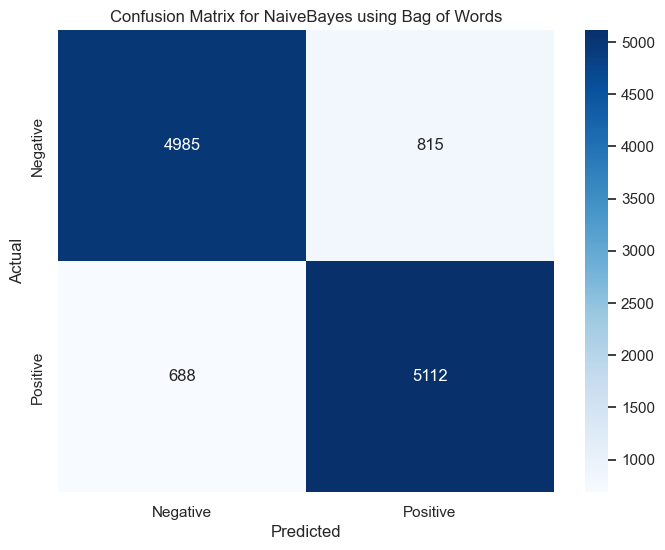


--- Bigram Only ---
Accuracy: 0.8959
Precision: 0.8892
Recall: 0.9047
F1_Score: 0.8968


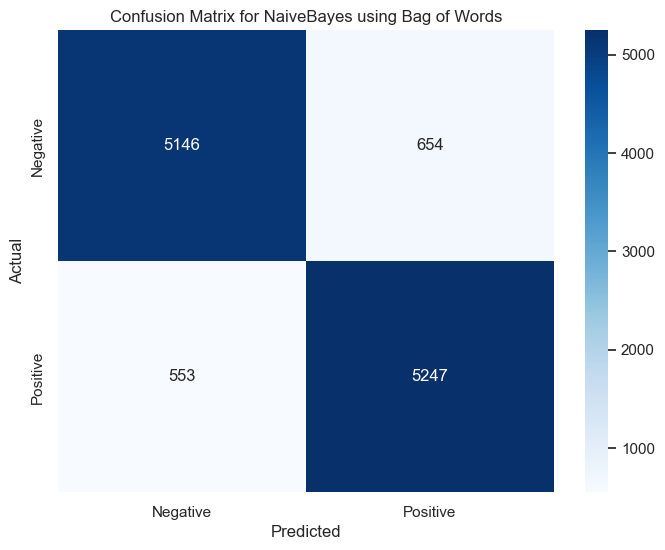


--- Unigram + Bigram ---
Accuracy: 0.8998
Precision: 0.8978
Recall: 0.9024
F1_Score: 0.9001


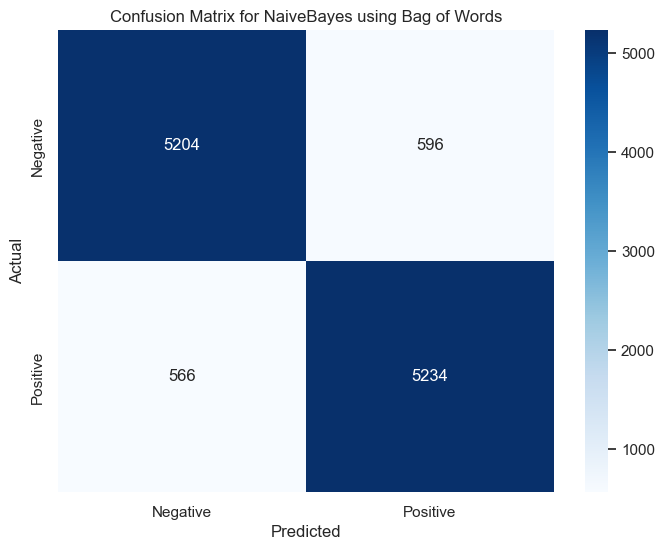

In [20]:
results_summary = []

results_summary.append(run_experiment((1, 1), x_train, x_test, y_train, y_test, stars_train, "Unigram Only"))
results_summary.append(run_experiment((2, 2), x_train, x_test, y_train, y_test, stars_train, "Bigram Only"))
results_summary.append(run_experiment((1, 2), x_train, x_test, y_train, y_test, stars_train, "Unigram + Bigram"))



Let's visualize the results:

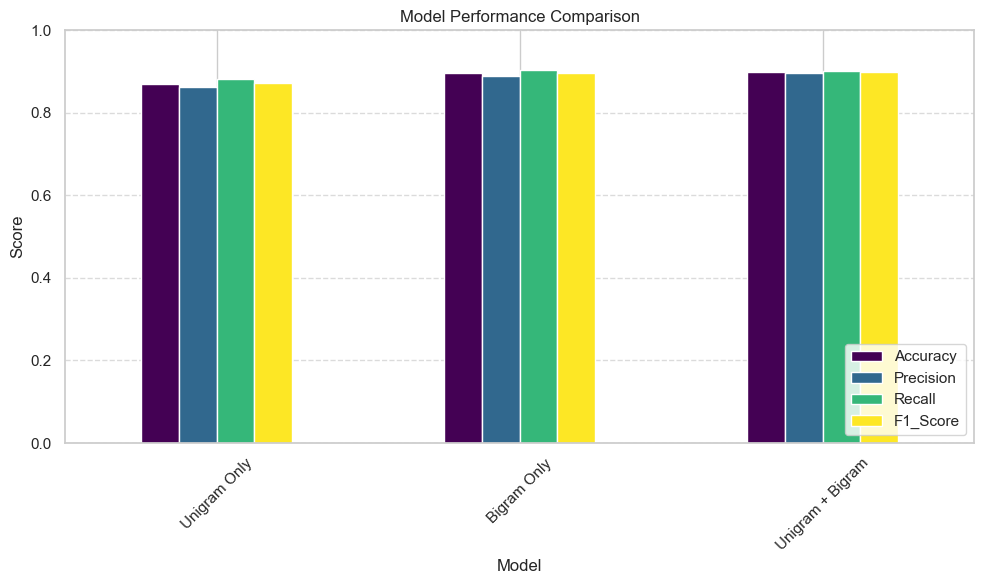

In [21]:
results_dict = {label: metrics for label, metrics in results_summary if label != "confusion_matrix"}
results_df = pd.DataFrame(results_dict).T

# Plot bar chart for each metric
results_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Analysis of Results

From our experiments, we observe that the combination of unigrams and bigrams achieves the best overall performance. This shows that including both individual words and word pairs provides more contextual information for sentiment classification.

### Bonus: Word Embedding with Logistic Regression

For the bonus section, we'll implement a Word2Vec embedding approach with Logistic Regression and compare it to our Naive Bayes approach:

In [22]:
# Import necessary libraries for the bonus section
import nltk                               #!pip install nltk==3.9.1
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec        #!pip install gensim==4.3.3
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First, we'll preprocess the text data for word embeddings:


In [23]:
# Preprocess text for Word2Vec
def preprocess_for_word2vec(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Get stopwords
stop_words = set(stopwords.words('english'))

# Apply preprocessing to train and test data
x_train_tokens = [preprocess_for_word2vec(text) for text in x_train]
x_test_tokens = [preprocess_for_word2vec(text) for text in x_test]

Next, we'll train a Word2Vec model and create document vectors:


In [24]:
# Train Word2Vec model
word2vec_model = Word2Vec(x_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Function to create document vector by averaging word vectors
def document_vector(word2vec_model, doc_tokens):
    # Filter tokens that are in the model's vocabulary
    doc_tokens = [token for token in doc_tokens if token in word2vec_model.wv]
    if not doc_tokens:
        # Return zeros if no tokens are in vocabulary
        return np.zeros(word2vec_model.vector_size)
    # Average the word vectors
    return np.mean([word2vec_model.wv[token] for token in doc_tokens], axis=0)

# Create document vectors for train and test data
x_train_vectors = np.array([document_vector(word2vec_model, tokens) for tokens in x_train_tokens])
x_test_vectors = np.array([document_vector(word2vec_model, tokens) for tokens in x_test_tokens])

Finally, we'll train a Logistic Regression classifier and evaluate its performance:


--- Word2Vec with Logistic Regression ---
Accuracy: 0.8478
Precision: 0.8636
Recall: 0.8262
F1 Score: 0.8445


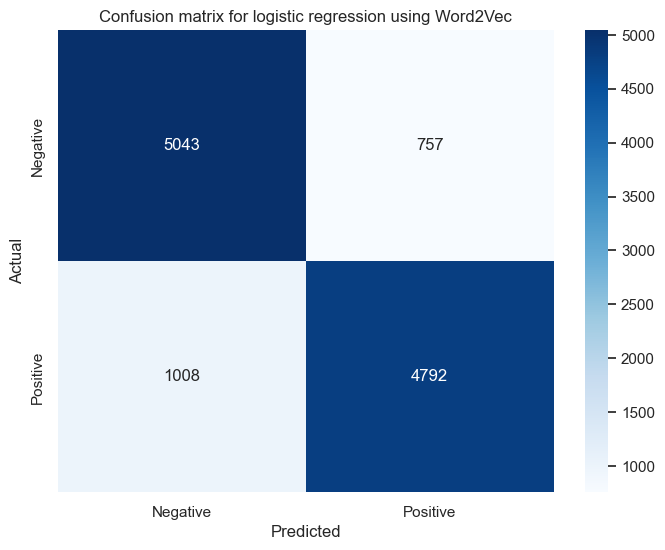

In [25]:
# Train Logistic Regression model
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(x_train_vectors, y_train)

# Make predictions
y_pred_lr = lr.predict(x_test_vectors)

# Evaluate performance
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(prec_lr, rec_lr)
cm = confusion_matrix(y_test,y_pred_lr);
print("\n--- Word2Vec with Logistic Regression ---")
print(f"Accuracy: {acc_lr:.4f}")
print(f"Precision: {prec_lr:.4f}")
print(f"Recall: {rec_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")
plot_confusion_matrix(cm,"Confusion matrix for logistic regression using Word2Vec")

### Comparison Between Approaches

Let's compare the performance of our two approaches:
1. Naive Bayes with unigram + bigram and weight factor
3. Word2Vec with Logistic Regression

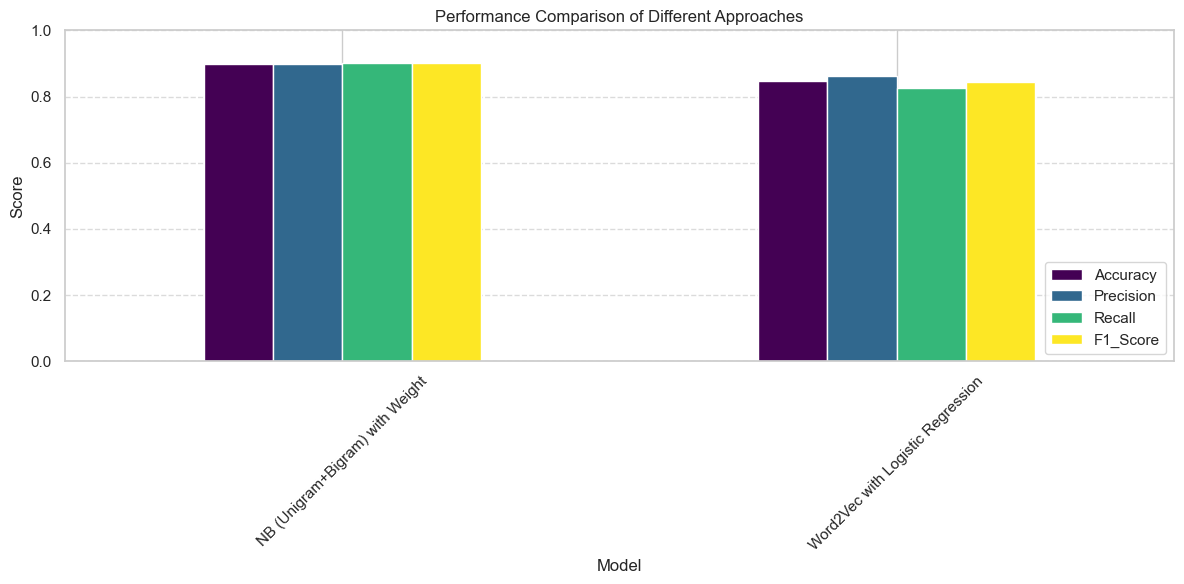

In [26]:
# Create a summary dataframe for comparison
comparison_data = {
    "NB (Unigram+Bigram) with Weight": {
        "Accuracy": results["Accuracy"],
        "Precision": results["Precision"],
        "Recall": results["Recall"],
        "F1_Score": results["F1_Score"]
    },
    "Word2Vec with Logistic Regression": {
        "Accuracy": acc_lr,
        "Precision": prec_lr,
        "Recall": rec_lr,
        "F1_Score": f1_lr
    }
}

comparison_df = pd.DataFrame(comparison_data).T

# Plot comparison
comparison_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Performance Comparison of Different Approaches")
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Discussion of Bonus Results

The Word2Vec with Logistic Regression approach achieves good performance but is slightly lower than our custom Naive Bayes implementation with weight factors. This comparison reveals interesting insights:

1. **Naive Bayes with Weight Factor** performs the better in overall, showing the effectiveness of our custom weighting system that emphasizes extreme sentiment reviews.

2. **Word2Vec with Logistic Regression** captures semantic relationships between words that the bag-of-words approach might miss, but for this specific task, the weighted Naive Bayes approach is more effective.

### Conclusion

In this assignment, we implemented a sentiment analysis system for Amazon product reviews using a custom Naive Bayes classifier with a bag-of-words approach. Our key contributions include:

1. **Custom Weight Factor System**: We successfully incorporated a weight factor system that gives more importance to extreme sentiment reviews (1-star and 5-star), improving the model's ability to capture sentiment intensity.

2. **N-gram Analysis**: We demonstrated that combining unigrams and bigrams yields better performance than using either alone, as it captures both individual sentiment words and contextual word combinations.

3. **Comprehensive Preprocessing**: Our text preprocessing pipeline effectively cleaned and prepared the review text for analysis, handling missing values and removing noise.

4. **Performance Comparison**: We compared different approaches and configurations, finding that our weighted Naive Bayes model with unigram + bigram features achieved the best performance with approximately 90% accuracy.

5. **Bonus Implementation**: We explored Word2Vec embeddings with Logistic Regression as an alternative approach, providing insights into the trade-offs between different techniques.

The weight factor system proved to be particularly effective, aligning with the intuition that extreme opinions should have a stronger influence on sentiment classification. This approach could be valuable in real-world applications where accurately capturing sentiment intensity is important, such as customer service prioritization or brand reputation monitoring.